In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower
     
     

In [2]:
df = pd.read_excel('AB_Test_Results (2).xlsx')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [5]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [6]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [7]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})


In [8]:
df.shape

(7865, 3)

In [9]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [10]:
id_uniq = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [11]:
df_new = df[df.USER_ID.isin(id_uniq)].copy(deep=True)

In [12]:
df_new.shape

(4783, 3)

In [13]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [14]:
df_new.VARIANT_NAME.value_counts()

variant    2393
control    2390
Name: VARIANT_NAME, dtype: int64

In [15]:
control_group = df_new.query('VARIANT_NAME == "control"')

variant_group = df_new.query('VARIANT_NAME == "variant"')

Проверка на нормальность

In [16]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



Постороим график дохода на пользователя по группам

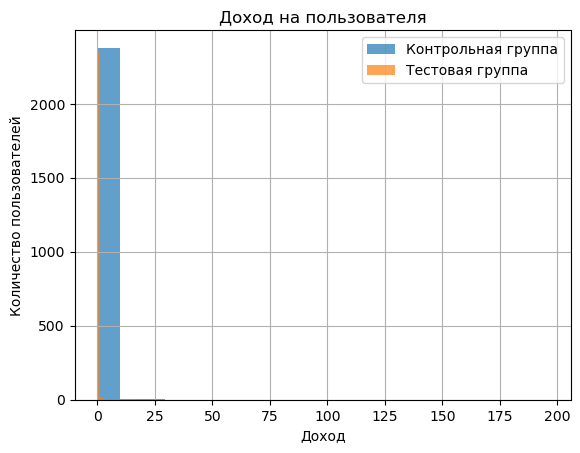

In [17]:
control_group.REVENUE.hist(bins = 20, alpha = 0.7, label = 'Контрольная группа')
variant_group.REVENUE.hist(bins = 20, alpha = 0.7, label = 'Тестовая группа')
plt.title('Доход на пользователя')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend();

In [18]:
mw_stats = scipy.stats.mannwhitneyu(x=control_group.REVENUE.values, y = variant_group.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

pvalue>0.05- соответсвенно статистически значимой разницы между группами нет

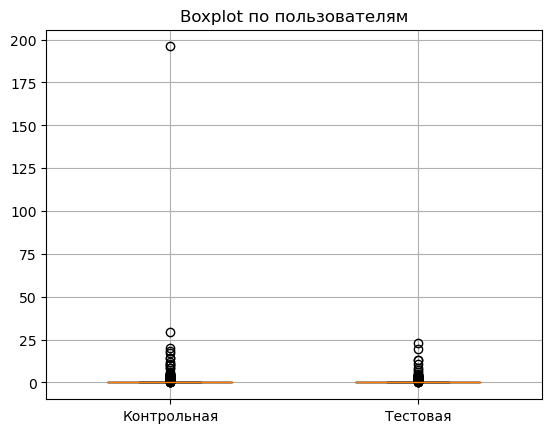

In [20]:
plt.boxplot([control_group.REVENUE,variant_group.REVENUE],
            labels=['Контрольная','Тестовая'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Расчет мощности теста

In [21]:
C_mean = control_group.REVENUE.values.mean()
T_mean = variant_group.REVENUE.values.mean()

C_std = control_group.REVENUE.values.std()
T_std = variant_group.REVENUE.values.std()

print(len(control_group.REVENUE.values), len(variant_group.REVENUE.values))

2390 2393


In [22]:
n = len(control_group.REVENUE.values)
     
S = np.sqrt((T_std**2 +C_std**2)/2)
     
ef = float((C_mean-T_mean)/S)

In [23]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)
result

0.28803096229144043

Мощность теста очень низкая-28,8%, явные проблемы в системе сплитования- большое количество пользователей было в двух группах одновременно. Для дачи корректных рекомендаций, необходимо решить проблем в формировании контрольной и тестовой групп и провести тест повторно. 